# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Some Pre-requisites

#### Import libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pickle
import random
import cv2
import time

%matplotlib inline
print('imports finished')

imports finished


## Step 1: Loading & preparing the data

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Load pickled data
# Pickle is used to serialize the data so that it can be saved to a disk

training_file = './data/train.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)

#Each pickled dataset is a dictionary of 4 keys
#dict_keys(['sizes', 'labels', 'features', 'coords'])
#print(train.keys())

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

In [4]:
#Initializations

#Check if the Number of labels are same as number of input images
assert(len(X_train) == len(y_train))
n_train = len(X_train)

assert(len(X_valid) == len(y_valid))
n_valid = len(X_valid)

# Image Shape
image_shape = X_train[0].shape
#print(image_shape)

# Number of classes / labels
n_classes = len(np.unique(y_train))

#### Lable Names 

In [5]:
def readcsv(file):
    with open(file) as csvfile:
        reader = csv.DictReader(csvfile)
        label_dict = {row['ClassId']:row['SignName'] for row in reader}
        return label_dict

count, label = np.unique(y_train, return_counts=True)
label_dict = readcsv('signnames.csv')

def get_label_name(label_no):
    return label_dict[label_no]

#### Image Pre-processing
As part of this step, each image is processed in the following sequence
- Images in Training set are in order, so to get better results and prevent overfitting, shuffle the dataset. Shuffling should be done for both Images & labels in sync.
- Gray Scale Conversion : Modifying the images to Gray scale will reduce the computational requirements
- CLAHE : This is called Adaptive Histogram Equalization which enhances the contrast of an image which helps for easy detection
- Normalize : Image normalization makes sure the data is zero-centered so that the gradient descent works effectively
After the pre-processing, the images are assinged back to the same variables

In [6]:
def grayscale(img_set):
    gray_img_set = []
    for img in img_set:
            gray_img_set.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return gray_img_set


#Perform histogram equalization using CLAHE algorithm on grayscale images
def clahe_equalize(img_set):
    clahe_img_set = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    for img in img_set:
        clahe_img = np.expand_dims(clahe.apply(img), axis = 2)
        clahe_img_set.append(clahe_img)
    return clahe_img_set

def normalize(img_set):
    norm_img_set = []
    for img in img_set:
        norm_img_set.append((img - 127.5)/127.5)
    return norm_img_set

In [7]:
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)
X_train_gry = grayscale(X_train_shuffle)
X_train_clahe = clahe_equalize(X_train_gry)
X_train_shuffle_normalized = normalize(X_train_clahe)
X_train, y_train = X_train_shuffle_normalized, y_train_shuffle

X_valid_shuffle, y_valid_shuffle = shuffle(X_valid, y_valid)
X_valid_gry = grayscale(X_valid_shuffle)
X_valid_clahe = clahe_equalize(X_valid_gry)
X_valid_shuffle_normalized = normalize(X_valid_clahe)
X_valid, y_valid = X_valid_shuffle_normalized, y_valid_shuffle

In [8]:
#This snippet reads the label names from the csv file. Labels in the data set are numbers, and this file has the corresponding names
label, count = np.unique(y_train_shuffle, return_counts=True)
#print('count',count)
label_dict_shuffle = readcsv('signnames.csv')
#print('\nLabels vs Count to ensure this pair doesn\'t change post shuffling\n')
count_var = []
for i, j in zip(count, label):
    #print('{} :: {}'.format(label_dict_shuffle[repr(j)], i))
    count_var.append(i)

#### Histogram representation of the training set

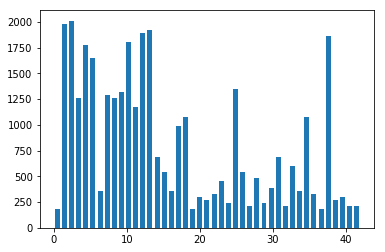

In [9]:
#Histogram display for original training set
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) /2
plt.bar(center, hist, align='center', width=width)
plt.show()

#### Data Augmentation
It is clear from the above histogram representation that some of the image classes has very small training set, and for the model to work effectively, data augmentation is done by duplicating the data set to have more number of images for each class

In this snippet, we ensure each class has atleast 800 Images in t

In [9]:
print('Before Augmentation', len(X_train))

#Data Augmentation
#print('X, y shapes:', X_train.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n) #This returns a tuple 0:array([  127,   259,   330 ...], dtype=int64), hence later we get only [0] element from this tuple
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(len(X_train))
            new_img = X_train[class_indices[0][i % n_samples]]
            #new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train = np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('After Augmentation', len(X_train))

Before Augmentation 34799
0 : |----|----|----|----|----|----|----|----|----|----|----|----|-
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|---
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|
15 : |----|----|----|----|----|
16 : |----|----|----|----|----|----|----|----|---
17 : 
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|----|-
20 : |----|----|----|----|----|----|----|----|----|----
21 : |----|----|----|----|----|----|----|----|----|----|--
22 : |----|----|----|----|----|----|----|----|----|-
23 : |----|----|----|----|----|----|----
24 : |----|----|----|----|----|----|----|----|----|----|----|
25 : 
26 : |----|----|----|----|----|
27 : |----|----|----|----|----|----|----|----|----|----|----|---
28 : |----|----|----|----|----|----|-
29 : |----|----|----|----|----|----|----|----|----|----|----|
30 : |----|----|----|----|----|----|----|----|
31 : |----|----|
32 : |----|----|----|----|----|----|----|----|----|----|----|---
33 : |----|-

#### Histogram representation of the training data set - After Augmentation

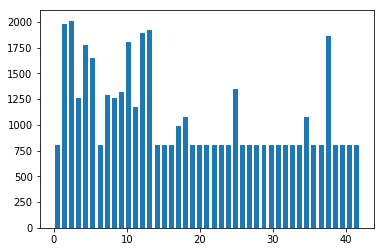

In [10]:
#Histogram display
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) /2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Neural Network Model
This is based on LeNet Architecture by Yann LeCunn

#### Constants for the training model

In [9]:
LEARN_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 60
KEEP_PROB = 0.5

In [10]:
# Conv --> MaxPool --> Conv --> MaxPool --> FC1 --> FC2 --> o/p
def NN_LeNet(inputs):
    """
    LeNet Architecture
    CN1 --> P1 --> CN2 --> P2 --> Flatten --> FC1 --> FC2 --> O/P
    Each step after CN & FC follows by an activation layer
    Here are the dimensions of LeNet

    Input : 32, 32, 1 #Gray scale has 1 channel. If you are using color images, this has to be 3
    Layer1 : CN1 Output : 28, 28, 6
    Layer2 : P1 Output  : 14, 14, 6
    Layer3 : CN2 Output : 10, 10, 16
    Layer4 : P2 Output  : 5, 5, 32
    Layer5 : FC1 Output : 120
    Layer6 : FC2 Output : 84
    Layer7 : Logits     : 43 #43 different classes in German Traffic Sign dataset
    """

    #Defining weights, bias and outputs for each Layer
    mu = 0 #Mean of the variables in the random distribution
    sigma = 0.1 #Variance is 0.1
    
    #Layer1 - Convolution - Output Size : 28, 28, 6
    #After conversion to Gray scale, the dimension size is 1 instead of 3 (RGB)
    w_layer1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    b_layer1 = tf.Variable(tf.zeros(6))
    conv_layer1 = tf.nn.conv2d(inputs, w_layer1, strides=[1,1,1,1], padding='VALID') + b_layer1
    act_layer1 = tf.nn.relu(conv_layer1)
    #drop_layer1 = tf.nn.dropout(act_layer1, KEEP_PROB)

    #Layer2 - Max Pooling - Output Size : 14, 14, 6
    pool_layer2 = tf.nn.max_pool(act_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer3 - Convolution - Output Size : 10, 10, 16 ==> 16 filters, size is (W + 2P - F)/S + 1
    #Filters changed to 32 - deviating from LeNet architecture
    w_layer3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 32), mean=mu, stddev=sigma))
    b_layer3 = tf.Variable(tf.zeros(32))
    conv_layer3 = tf.nn.conv2d(pool_layer2, w_layer3, strides=[1, 1, 1, 1], padding='VALID') + b_layer3
    act_layer3 = tf.nn.relu(conv_layer3)
    #drop_layer3 = tf.nn.dropout(act_layer3, KEEP_PROB)

    #Layer4 - Max Pooling - Output Size : 5, 5, 16
    pool_layer4 = tf.nn.max_pool(act_layer3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatenning as next layers are fully connected
    flatten_vect = tf.contrib.layers.flatten(pool_layer4)

    #Layer5 - Fully Connected - Output = 120. Input dimension would be 5*5*16 = 400
    # Since the filters are 32 in earlier step, dimension would be 5*5*32 = 800
    w_layer5 = tf.Variable(tf.random_normal(shape=(800, 120), mean=mu, stddev=sigma))
    b_layer5 = tf.Variable(tf.zeros(120))
    fc_layer5 = tf.matmul(flatten_vect, w_layer5) + b_layer5
    act_layer5 = tf.nn.relu(fc_layer5)
    drop_layer5 = tf.nn.dropout(act_layer5, KEEP_PROB)

    #Layer6 - Fully Connected - Output = 84. Input dimension is 120
    w_layer6 = tf.Variable(tf.random_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b_layer6 = tf.Variable(tf.zeros(84))
    fc_layer6 = tf.matmul(drop_layer5, w_layer6) + b_layer6
    act_layer6 = tf.nn.relu(fc_layer6)
    drop_layer6 = tf.nn.dropout(act_layer6, KEEP_PROB)

    #Layer7 - Logits - Output Size : 43 types of image classes in the input dataset
    w_layer7 = tf.Variable(tf.random_normal(shape=(84, 43), mean=mu, stddev=sigma))
    b_layer7 = tf.Variable(tf.zeros(43))
    logits = tf.matmul(drop_layer6, w_layer7) + b_layer7
    
    return logits

### Defining Input Variables
This is for storing the individual batch features & labels
The inputs will be fed at runtime from the batches made out of training data set

Batchsize is None so that it can accept a batch of anysize later at runtime

In [11]:
#None is a placeholder which depends on the number of input images in the batch (k)
#Observe that input data will be float, but labels will always be integers. Otherwise one hot doesn't work
input_data = tf.placeholder(tf.float32, (None, 32, 32, 1))
input_labels = tf.placeholder(tf.int32, (None))
one_hot_labels = tf.one_hot(input_labels, 43)

### Training Pipeline
In this pipeline, we train the model by calculating the following
Logits are calculated using the Neural Network
Cross Entropy loss is the difference between the logits vector and ground truth(in the form of one hot encoded vector)
Average over cross entropy of all the training images (of this batch)
Minimize the loss using Adam Optimizer
Using the loss determined, backprop and adjust weights

THis results in a pipeline that can be used for training. But data has to be fed to this pipeline so that the NN can be trained

In [12]:
logits = NN_LeNet(input_data)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
training_operation = optimizer.minimize(loss)

### Evaluating the Model
In this cell, we evaluate the model by comparing the output of the model to the ground truth
Correct Prediction is determined by comparing the logits output to the ground truth variables(in one-hot format)
Then Accuracy of your model is measured by calculating the model's overall accuracy by calculating the individual accuracies
Evaluate function takes complete input data, splits into batches to calculate the accuracy and finally combines it

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(x_data, y_data):
    total_accuracy = 0
    length_inputs = len(x_data)
    sess = tf.get_default_session()
    for offset in range(0, length_inputs, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_accuracy = sess.run(accuracy, feed_dict={input_data:batch_x, input_labels:batch_y})
        total_accuracy += (batch_accuracy * len(batch_x))
    return total_accuracy / length_inputs

### Train the Model
In this cell, we train the model
Shuffle the inputs so that your model is not dependent on the order of the inputs
Use the training_operation which is defined in the 'Training Pipeline' to do a fwd/back pass and update the weights and biases


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

- Note : It is observed that having dropout layers only on fully connected layers yeilds more accuracy than to have the dropouts on COnvolution layers. The differece is about 1% as observed in about 10 different training cycles

Training...
EPOCH 1    Training Accuracy = 0.586 Validation Accuracy = 0.553
EPOCH 2    Training Accuracy = 0.756 Validation Accuracy = 0.725
EPOCH 3    Training Accuracy = 0.830 Validation Accuracy = 0.790
EPOCH 4    Training Accuracy = 0.856 Validation Accuracy = 0.823
EPOCH 5    Training Accuracy = 0.885 Validation Accuracy = 0.841
EPOCH 6    Training Accuracy = 0.903 Validation Accuracy = 0.857
EPOCH 7    Training Accuracy = 0.914 Validation Accuracy = 0.869
EPOCH 8    Training Accuracy = 0.922 Validation Accuracy = 0.871
EPOCH 9    Training Accuracy = 0.929 Validation Accuracy = 0.893
EPOCH 10    Training Accuracy = 0.933 Validation Accuracy = 0.890
EPOCH 11    Training Accuracy = 0.940 Validation Accuracy = 0.906
EPOCH 12    Training Accuracy = 0.943 Validation Accuracy = 0.893
EPOCH 13    Training Accuracy = 0.947 Validation Accuracy = 0.901
EPOCH 14    Training Accuracy = 0.950 Validation Accuracy = 0.907
EPOCH 15    Training Accuracy = 0.952 Validation Accuracy = 0.916
EPOCH 1

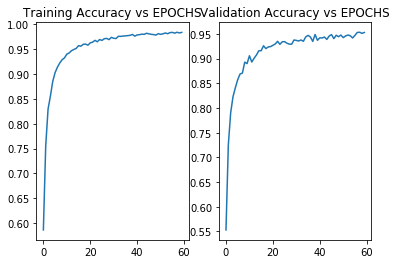

In [14]:
model_file = './traffic_sign_model'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_total = len(X_train)
    validation_accuracy_plot = []
    train_accuracy_plot = []
    print('Training...')
    start_time = time.time()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_total, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={input_data:batch_x, input_labels:batch_y})
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print('EPOCH {}    Training Accuracy = {:.3f} Validation Accuracy = {:.3f}'.format(i+1, training_accuracy, validation_accuracy))
        
        train_accuracy_plot.append(training_accuracy)
        validation_accuracy_plot.append(validation_accuracy)
        
    plt.figure(3)
    plt.subplot(121)
    plt.plot(train_accuracy_plot)
    plt.title('Training Accuracy vs EPOCHS')
    plt.subplot(122)
    plt.plot(validation_accuracy_plot)
    plt.title('Validation Accuracy vs EPOCHS')
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, model_file)
    
    print('Total time for training {:.3f}'.format(time.time() - start_time))
    print('Model Saved to', model_file)
    

#### Evaluating the model with Test set

In [15]:
testing_file = './data/test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#Each pickled dataset is a dictionary of 4 keys
#dict_keys(['sizes', 'labels', 'features', 'coords'])
#print(test.keys())
X_test, y_test = test['features'], test['labels']
print('Length of Test Set {}'.format(len(X_test)))
#Same pre-processing as the training set
X_test_shuffle, y_test_shuffle = shuffle(X_test, y_test)
X_test_gry = grayscale(X_test_shuffle)
X_test_clahe = clahe_equalize(X_test_gry)
X_test_shuffle_normalized = normalize(X_test_clahe)
X_test, y_test = X_test_shuffle_normalized, y_test_shuffle

Length of Test Set 12630


In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./traffic_sign_model.meta')
    saver2.restore(sess, './traffic_sign_model') 
    test_accuracy = evaluate(X_test, y_test)
    print('Test Set Accuracy = {:.3f}'.format(test_accuracy))

Test Set Accuracy = 0.935


#### Accuracy on the test set - which was never seen by the model is 93.5%

---

## Step 3: Test a Model on New Images

- 6 random images are downloaded from internet in 32x32 color images. Hence this is of the same dimensions as our training set
- Ground truth for these labels are defined by looking at the images and assigning them values by looking at the `signatures.csv`

### Load and Output the Images

In [ ]:
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(2,4, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./data/ImagesFromNet/*.png')):
    image = cv2.imread(img)
    cv2.imshow(image, cv2.COLOR_BGR2RGB)
#     axs[i].axis('off')
#     axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

my_images = np.asarray(my_images)

# my_images_gry = np.sum(my_images/3, axis=3, keepdims=True)

# my_images_normalized = (my_images_gry - 128)/128 

print(my_images.shape)

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")